# Advanced Lane Finding Project

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
- Video pipeline

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

# Camera calibration

In [2]:
def showImages(images, cols = 4, rows = 5, figsize=(15,10)):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            ax.imshow(image)
            ax.set_title(imagePathName)

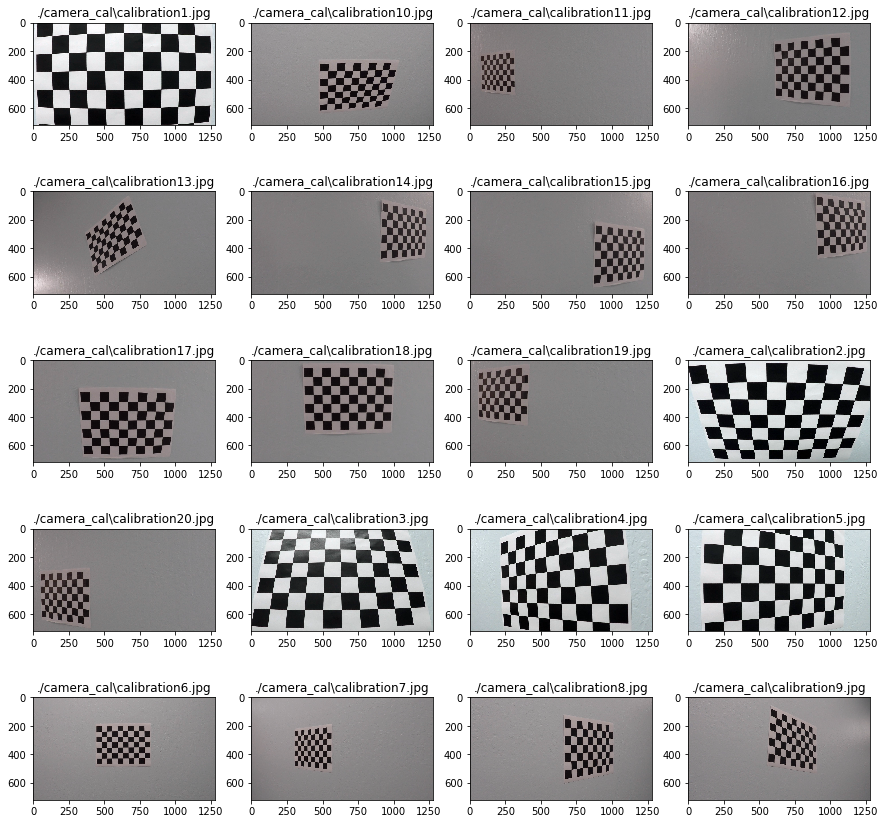

In [3]:
# Load calibration images.
calibrationImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), glob.glob('./camera_cal/c*.jpg')))
showImages(calibrationImages, 4, 5, (15, 15))

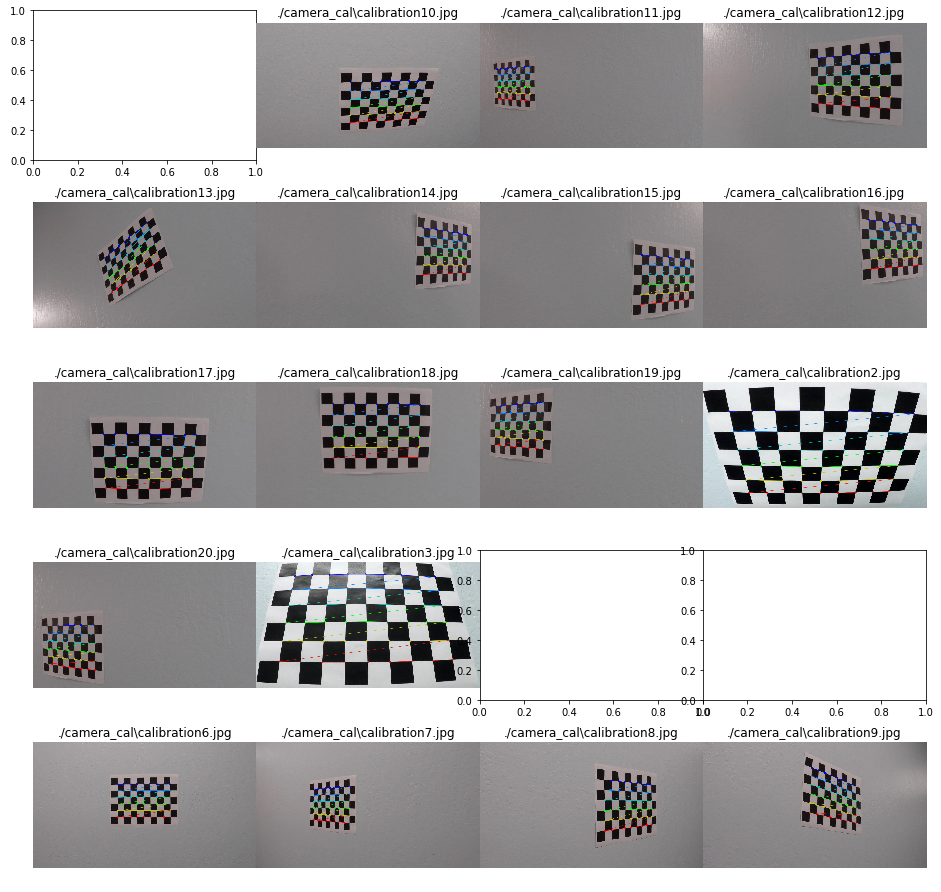

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)

        # this step to refine image points was taken from:
        # http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
    
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)
        axs[i].set_title(fname)


In [5]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
pickle.dump( { 'mtx': mtx, 'dist': dist }, open( './data/camera_calibration.p', 'wb' ) )


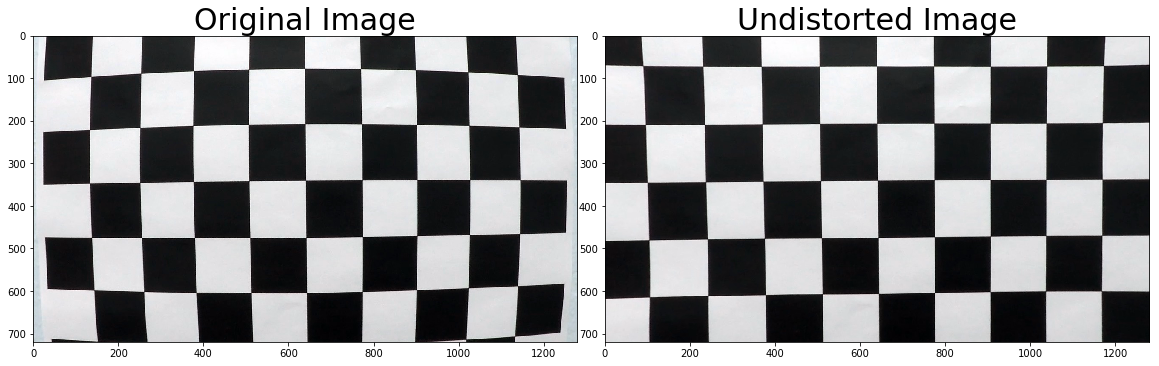

In [6]:
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


In [7]:
# Loading camera calibration
cameraCalibration = pickle.load( open('./data/camera_calibration.p', 'rb' ) )
mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

# Correct distortion for test images.

In [8]:
# Load test images.
testImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), 
                      glob.glob('./test_images/*.jpg')))


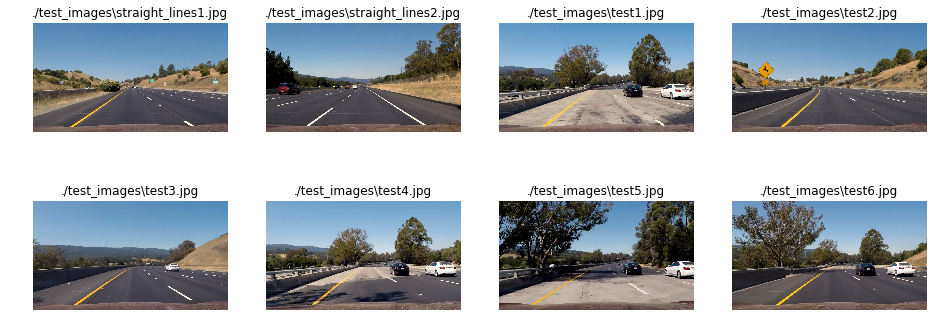

In [9]:
def showImages(images, cols = 4, rows = 5, figsize=(15,10), cmap = None):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            if cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap=cmap)
            ax.set_title(imagePathName)
            ax.axis('off')
        
showImages(list(map(lambda img: (img[0], cv2.cvtColor(img[1], cv2.COLOR_BGR2RGB)),testImages)), 4, 2, (16, 6))

In [10]:
exampleImg = cv2.imread('./test_images/test3.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)

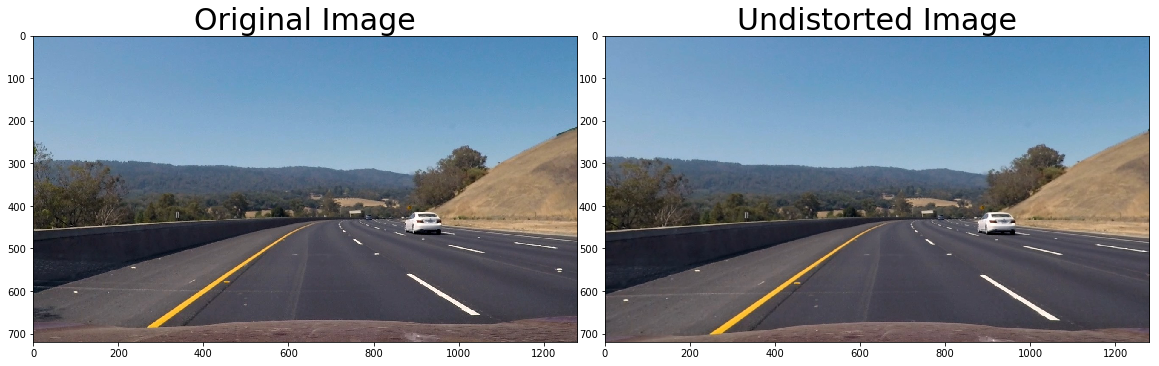

In [11]:
exampleImg_undistort =  cv2.undistort(exampleImg, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(exampleImg_undistort)
ax2.set_title('Undistorted Image', fontsize=30)


# Use color transforms, gradients, etc., to create a thresholded binary image.


In [12]:
def undistortAndHLS(image, mtx=mtx, dist=dist):
    """
    Undistort the image with `mtx`, `dist` and convert it to HLS.
    """
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)



In [13]:
index = 4
original = testImages[index][1]
hlsOriginal = undistortAndHLS(original)

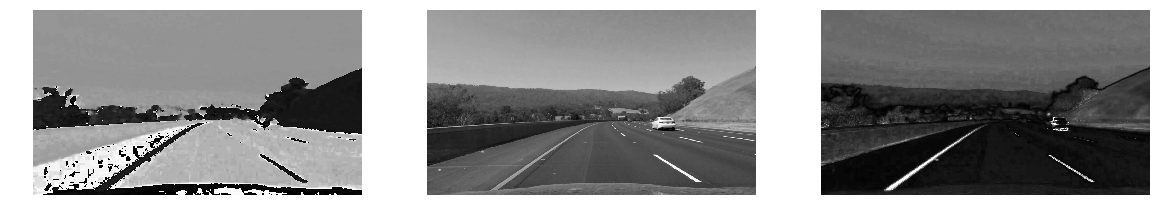

In [14]:
# explore the color space
fig, axes = plt.subplots(ncols=3, figsize=(20,10))
for index, a in enumerate(axes):
    a.imshow(hlsOriginal[:,:,index], cmap='gray')
    a.axis('off')

In [15]:
def absSobelThresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    """
    Calculate the Sobel gradient on the direction `orient` and return a binary thresholded image 
    on [`thresh_min`, `thresh_max`]. Using `sobel_kernel` as Sobel kernel size.
    """
    if orient == 'x':
        yorder = 0
        xorder = 1
    else:
        yorder = 1
        xorder = 0
        
    sobel = cv2.Sobel(img, cv2.CV_64F, xorder, yorder, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255.0*abs_sobel/np.max(abs_sobel))
  
    """
    Applies a threshold to the `img` using [`thresh_min`, `thresh_max`] returning a binary image [0, 255]
    """
    xbinary = np.zeros_like(scaled)
    xbinary[(scaled >= thresh_min) & (scaled <= thresh_max)] = 1
    return xbinary



In [16]:
useSChannel = lambda img: undistortAndHLS(img)[:,:,2]

In [17]:
withSobelX = lambda img: absSobelThresh(useSChannel(img), thresh_min=10, thresh_max=160)
withSobelY = lambda img: absSobelThresh(useSChannel(img), orient='y', thresh_min=10, thresh_max=160)

## Combining Gradients

In [18]:
def combineGradients(img):
    """
    Compute the combination of Sobel X and Sobel Y or Magnitude and Direction
    """
    sobelX = withSobelX(img)
    sobelY = withSobelY(img)
    combined = np.zeros_like(sobelX) 
    combined[((sobelX == 1) & (sobelY == 1))] = 1
    return combined

In [19]:
def applyAndShow(images, action, cmap='gray'):
    """
    images is a colletion of pairs (`title`, image).
    Applies `action` to the image part of collection `images` (`title`, image),
    show the images and titles and return
    (`title`, `action`(image))
    """
    
    #applies `action` to the image part of `images` and pack the pair again to form (`title`, `action`(image)).
    output = list(map(lambda img: (img[0], action(img[1])), images))
    showImages( output, 4, 2, (16, 6), cmap=cmap)
    return output

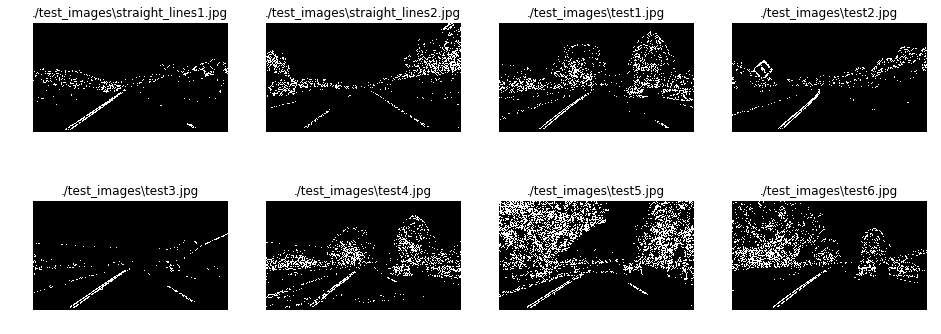

In [20]:
resultCombined = applyAndShow(testImages, combineGradients)

### Perspective Transform

In [21]:
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

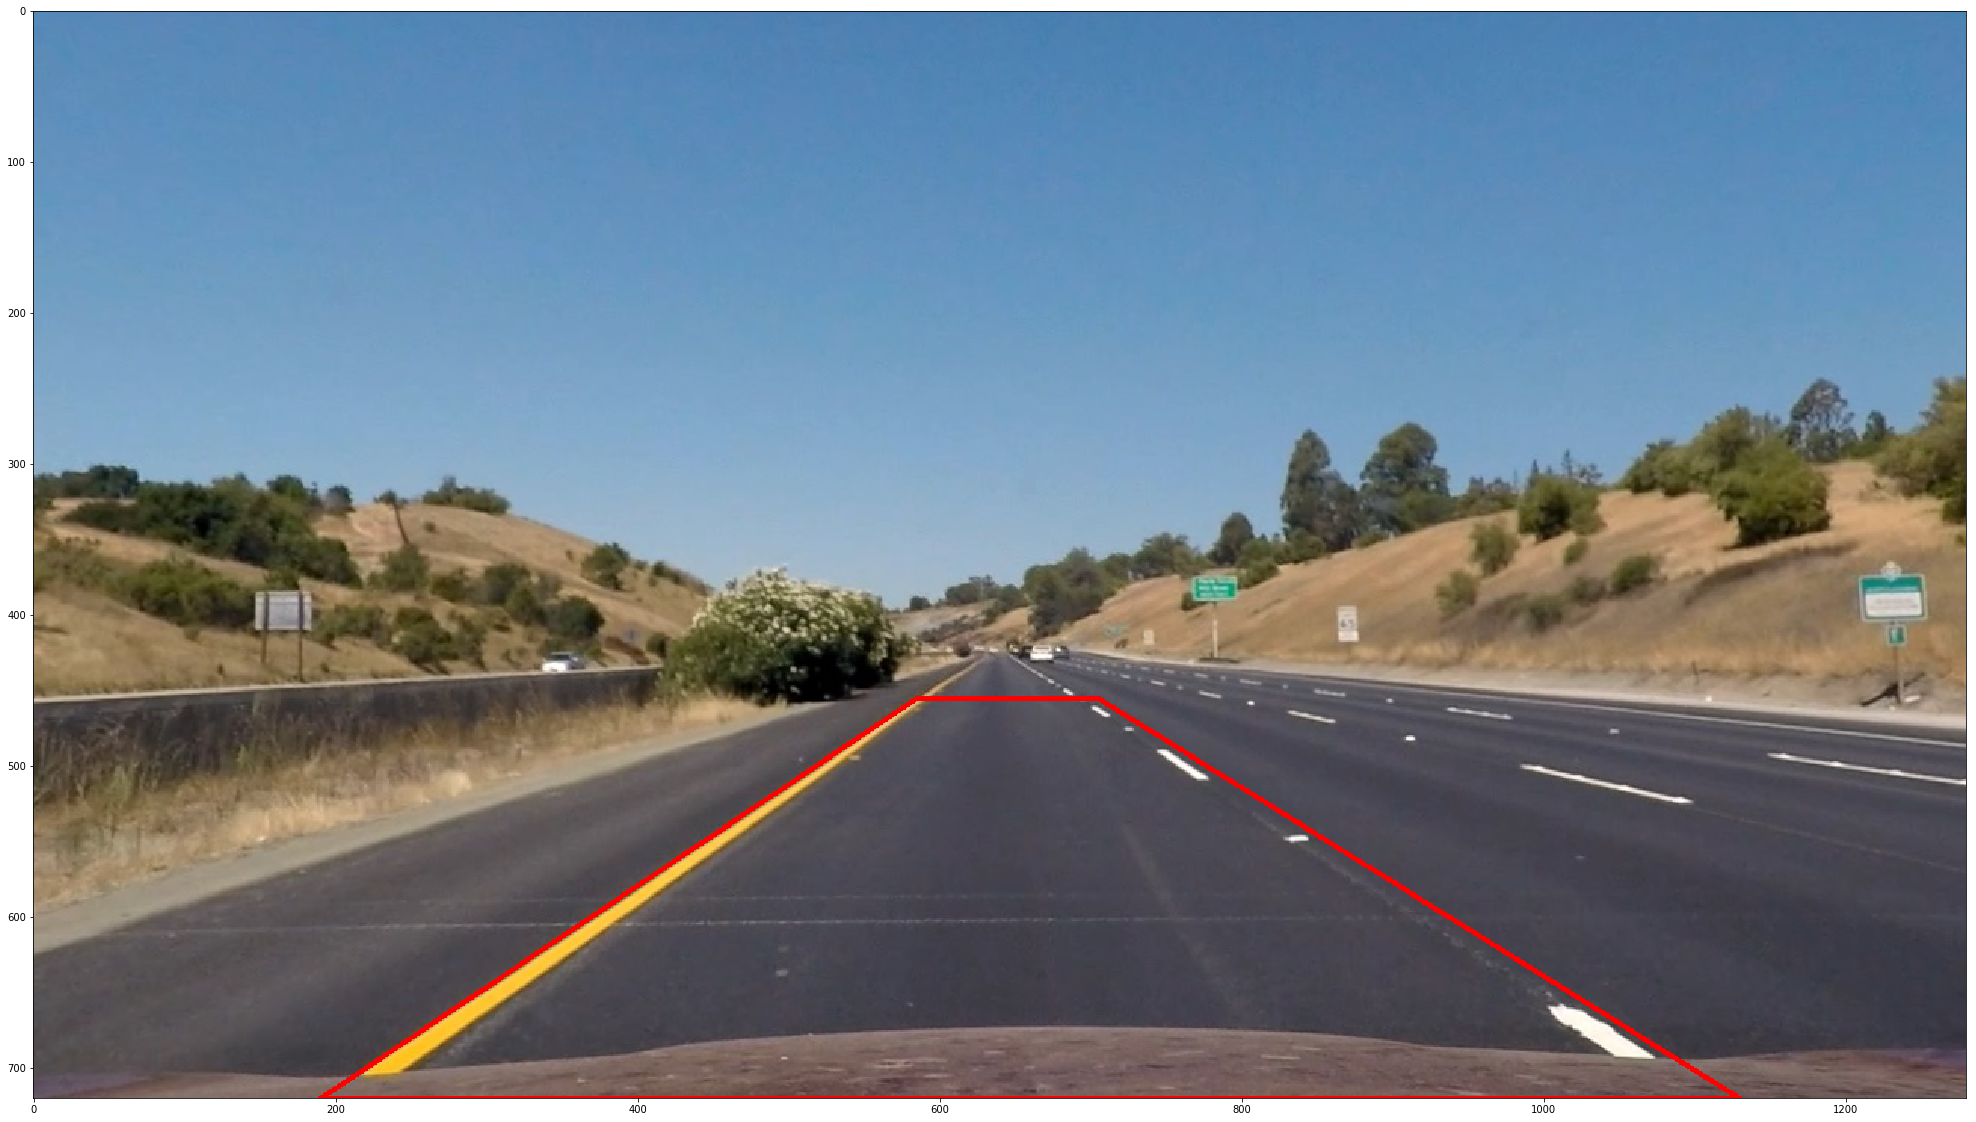

In [22]:
index = 0
original = cv2.cvtColor(testImages[index][1],cv2.COLOR_BGR2RGB)
undist = cv2.undistort(original, mtx, dist, None, mtx)

xSize, ySize, _ = undist.shape
copy = undist.copy()

bottomY = 720
topY = 455


left1 = (190, bottomY)
left1_x, left1_y = left1
left2 = (585, topY)
left2_x, left2_y = left2

right1 = (705, topY)
right1_x, right1_y = right1

right2 = (1130, bottomY)
right2_x, right2_y = right2

color = [255, 0, 0]
w = 2
cv2.line(copy, left1, left2, color, w)
cv2.line(copy, left2, right1, color, w)
cv2.line(copy, right1, right2, color, w)
cv2.line(copy, right2, left1, color, w)
fig, ax = plt.subplots(figsize=(40, 20))
ax.imshow(copy)


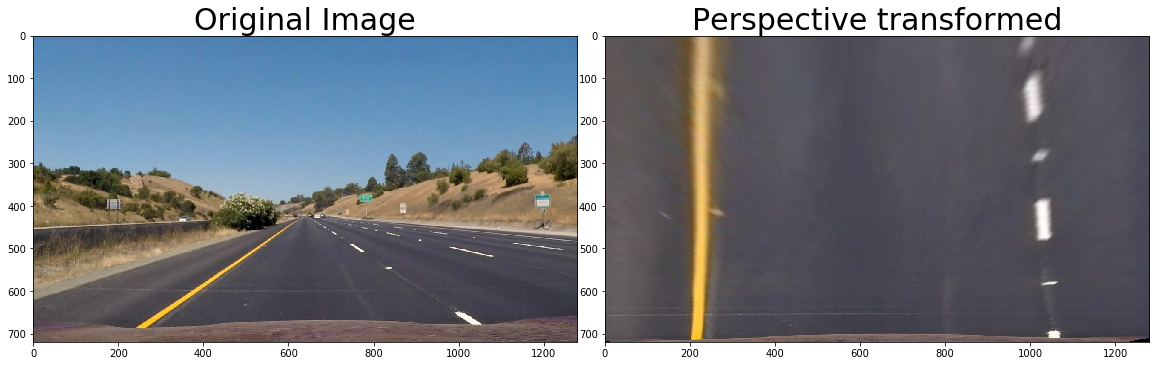

In [23]:
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
src = np.float32([ 
    [left2_x, left2_y],
    [right1_x, right1_y],
    [right2_x, right2_y],
    [left1_x, left1_y]
])
nX = gray.shape[1]
nY = gray.shape[0]
img_size = (nX, nY)
offset = 200
dst = np.float32([
    [offset, 0],
    [img_size[0]-offset, 0],
    [img_size[0]-offset, img_size[1]], 
    [offset, img_size[1]]
])
img_size = (gray.shape[1], gray.shape[0])

warped, M, Minv = unwarp(undist, src, dst)


# Visualize warped
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(original)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Perspective transformed', fontsize=30)






In [24]:
pickle.dump( { 'M': M, 'Minv': Minv }, open('./data/perspective_transform.p', 'wb'))
print(M)
print(Minv)

[[ -6.83269851e-01  -1.49897451e+00   1.06311163e+03]
 [ -4.99600361e-15  -1.98300615e+00   9.02267800e+02]
 [ -6.93889390e-18  -2.40257838e-03   1.00000000e+00]]
[[  1.36363636e-01  -7.78812057e-01   5.57727273e+02]
 [ -4.44089210e-16  -5.04284870e-01   4.55000000e+02]
 [ -2.16840434e-18  -1.21158392e-03   1.00000000e+00]]


# Apply Perspective Transform to Rectify Binary Image ( Result in "birds-eye view").


In [25]:
transMatrix = pickle.load( open('./data/perspective_transform.p', 'rb' ) )
M, Minv = map(transMatrix.get, ('M', 'Minv'))

In [26]:
def applyPerspective(image, M=M):
    #Apply the transformation matrix `M` on the image
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, M, img_size)
    return warped

combineAndTransform = lambda img: applyPerspective(combineGradients(img))

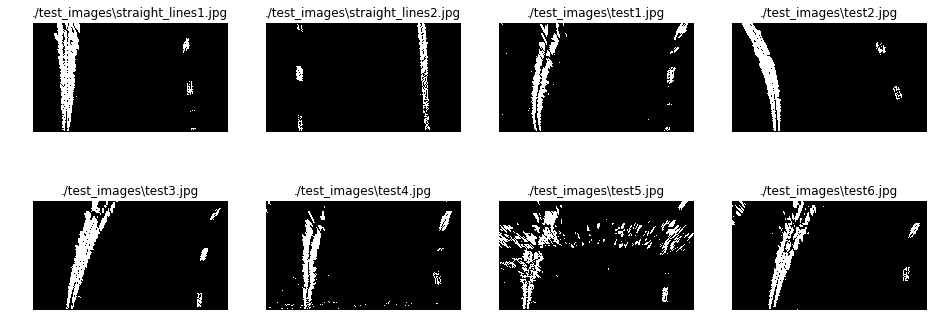

In [27]:
binary_warped = applyAndShow(testImages, combineAndTransform, cmap='gray')


# Find Lanes

First take a histogram along all the columns in the lower half of the image (use test image 0)

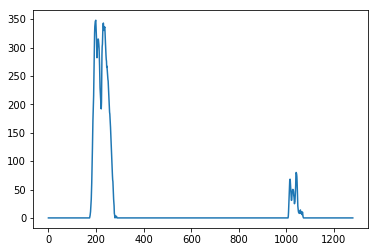

In [28]:
img = binary_warped[0][1]
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

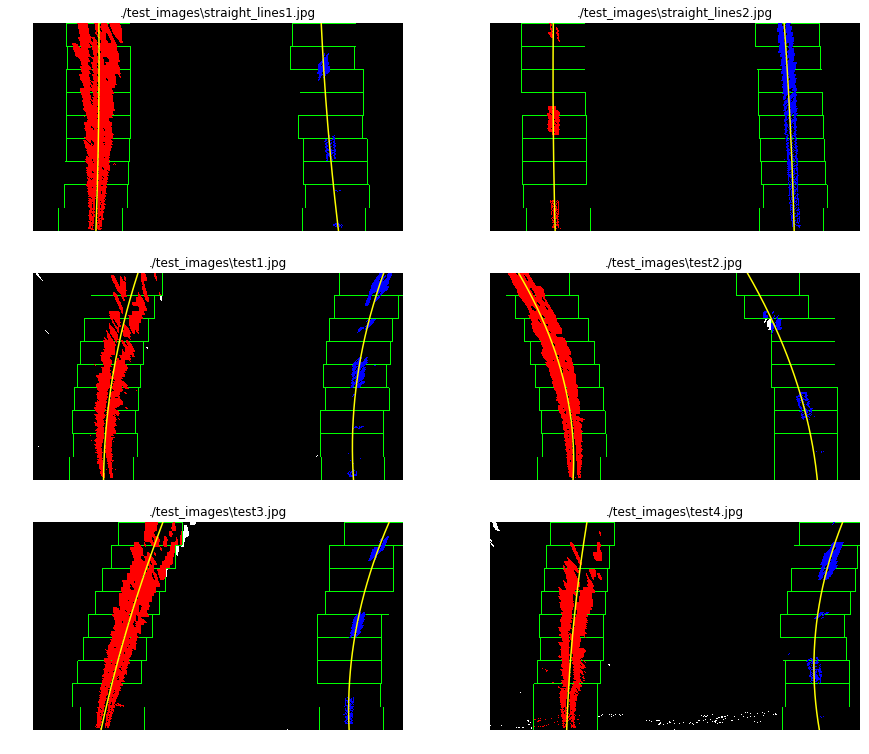

In [29]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def findLines(image, nwindows=9, margin=110, minpix=50):
    """
    Find the polynomial representation of the lines in the `image` using:
    - `nwindows` as the number of windows.
    - `margin` as the windows margin.
    - `minpix` as minimum number of pixes found to recenter the window.
    - `ym_per_pix` meters per pixel on Y.
    - `xm_per_pix` meters per pixels on X.
    
    Returns (left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)
    """    
    # Make a binary and transform image
    binary_warped = combineAndTransform(image)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)

def visualizeLanes(image, ax):
    """
    Visualize the windows and fitted lines for `image`.
    Returns (`left_fit` and `right_fit`)
    """
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = findLines(image)
    # Visualization
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ax.imshow(out_img)
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    return ( left_fit, right_fit, left_fit_m, right_fit_m )

def showLaneOnImages(images, cols = 2, rows = 3, figsize=(15,13)):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    Returns a collection with the image paths and the left and right polynomials.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    imageAndFit = []
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            left_fit, right_fit, left_fit_m, right_fit_m = visualizeLanes(image, ax)
            ax.set_title(imagePathName)
            ax.axis('off')
            imageAndFit.append( ( imagePathName, left_fit, right_fit, left_fit_m, right_fit_m ) )
    return imageAndFit

imagesPoly = showLaneOnImages(testImages)

# Measuring Curvature

In [30]:
#Returns the curvature of the polynomial `fit` on the y range `yRange`.
def calculate_curvature_left(yRange, left_fit_cr):
    return ((1 + (2*left_fit_cr[0]*yRange*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])

def calculate_curvature_right(yRange, right_fit_cr):

    return ((1 + (2 * right_fit_cr[0] * yRange * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])

for imagePoly in imagesPoly:
    imagePath, left_fit, right_fit, left_fit_m, right_fit_m = imagePoly
    yRange = 719
    leftCurvature = calculate_curvature_left(yRange, left_fit_m) / 1000
    rightCurvature = calculate_curvature_right(yRange, right_fit_m) / 1000
    print('Image : {}, Left : {:.2f} km, Right : {:.2f} km'.format(imagePath, leftCurvature, rightCurvature))
    

Image : ./test_images\straight_lines1.jpg, Left : 5.31 km, Right : 3.21 km
Image : ./test_images\straight_lines2.jpg, Left : 6.34 km, Right : 5.20 km
Image : ./test_images\test1.jpg, Left : 0.75 km, Right : 0.55 km
Image : ./test_images\test2.jpg, Left : 0.36 km, Right : 0.49 km
Image : ./test_images\test3.jpg, Left : 1.47 km, Right : 0.49 km
Image : ./test_images\test4.jpg, Left : 1.82 km, Right : 0.42 km


# Project the detected lane back onto the original image.

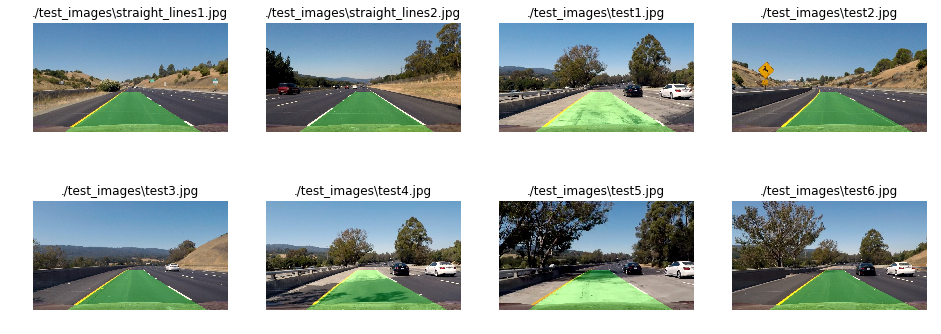

In [31]:
#Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
def drawLine(img, left_fit, right_fit):
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

#Find and draw the lane lines on the image `img`
def drawLaneOnImage(img):
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = findLines(img)
    output = drawLine(img, left_fit, right_fit)
    return cv2.cvtColor( output, cv2.COLOR_BGR2RGB )

resultLines = applyAndShow(testImages, drawLaneOnImage)

# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

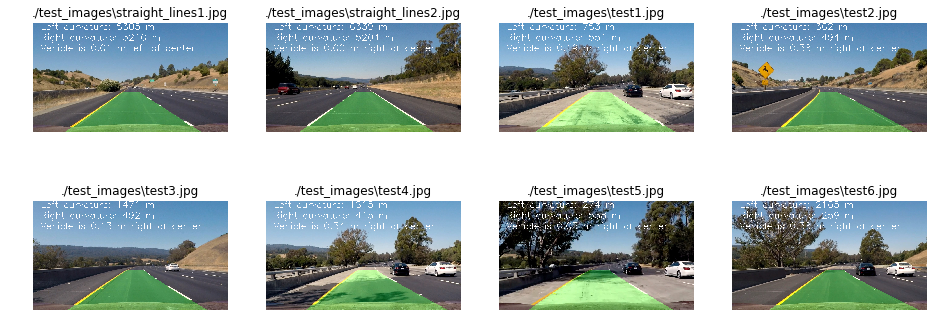

In [32]:
def pipeline(img, fontScale=2):
    """
    Find and draw the lane lines on the image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = findLines(img)
    output = drawLine(img, left_fit, right_fit)
    
    # Calculate curvature
    leftCurvature = calculate_curvature_left(yRange, left_fit_m) 
    rightCurvature = calculate_curvature_right(yRange, right_fit_m)
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(leftCurvature), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(rightCurvature), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (50, 190), font, fontScale, fontColor, 2)
    return output

resultDisplay = applyAndShow(testImages, lambda img: cv2.cvtColor(pipeline(img), cv2.COLOR_BGR2RGB ))

# Video pipeline

In [33]:
from moviepy.editor import VideoFileClip

class Lane():
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.left_fit_m = None
        self.right_fit_m = None
        self.leftCurvature = None
        self.rightCurvature = None

def calculateLanes(img):
    """
    Calculates the lane on image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = findLines(img)
    # Calculate curvature
    leftCurvature = calculate_curvature_left(yRange, left_fit_m) 
    rightCurvature = calculate_curvature_right(yRange, right_fit_m)
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle)

def displayLanes(img, left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle):
    """
    Display the lanes information on the image.
    """
    output = drawLine(img, left_fit, right_fit)
    
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(leftCurvature), (50, 50), font, 1, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(rightCurvature), (50, 120), font, 1, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (50, 190), font, 1, fontColor, 2)
    return output
    
def videoPipeline(inputVideo, outputVideo):
    """
    Process the `inputVideo` frame by frame to find the lane lines, draw curvarute and vehicle position information and
    generate `outputVideo`
    """
    myclip = VideoFileClip(inputVideo)
    
    leftLane = Lane()
    rightLane = Lane()
    
    def processImage(img):
        left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle = calculateLanes(img)
        if leftCurvature > 10000:
            left_fit = leftLane.left_fit
            left_fit_m = leftLane.left_fit_m
            leftCurvature = leftLane.leftCurvature
        else:
            leftLane.left_fit = left_fit
            leftLane.left_fit_m = left_fit_m
            leftLane.leftCurvature = leftCurvature
        
        if rightCurvature > 10000:
            right_fit = rightLane.right_fit
            right_fit_m = rightLane.right_fit_m
            rightCurvature = rightLane.rightCurvature
        else:
            rightLane.right_fit = right_fit
            rightLane.right_fit_m = right_fit_m
            rightLane.rightCurvature = rightCurvature
            
        return displayLanes(img, left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle)

    clip = myclip.fl_image(processImage)
    clip.write_videofile(outputVideo, audio=False)

# Project video
videoPipeline('project_video.mp4', 'output_videos/project_video.mp4')

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:53<00:00,  5.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

